In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!git clone https://github.com/jayeshthk/micrograd.git

Cloning into 'micrograd'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 98 (delta 39), reused 38 (delta 38), pack-reused 39
Receiving objects: 100% (98/98), 239.54 KiB | 21.78 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [5]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [6]:
np.random.seed(1337)
random.seed(1337)

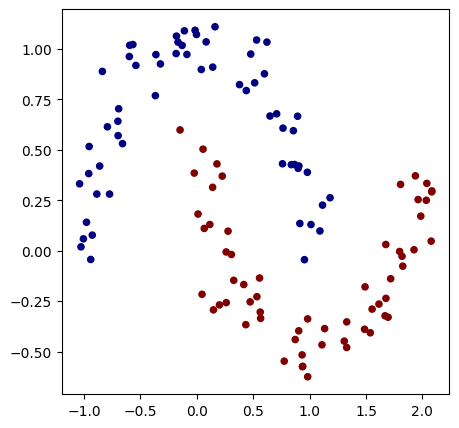

In [7]:
from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=120, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [39]:
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [40]:
def loss(batch_size=None):

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.4401635829356771, grad=0) 0.45


In [41]:
for k in range(50):

    # forward
    total_loss, acc = loss()

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 1.4401635829356771, accuracy 45.0%
step 1 loss 0.877540119610617, accuracy 50.0%
step 2 loss 0.7037552817773297, accuracy 71.66666666666667%
step 3 loss 0.6258491589657933, accuracy 73.33333333333333%
step 4 loss 0.6249157216521147, accuracy 76.66666666666667%
step 5 loss 0.37735310979254405, accuracy 83.33333333333334%
step 6 loss 0.29551713120106593, accuracy 86.66666666666667%
step 7 loss 0.23023648183421677, accuracy 90.83333333333333%
step 8 loss 0.1796458809590515, accuracy 92.5%
step 9 loss 0.15825546372116575, accuracy 94.16666666666667%
step 10 loss 0.17891814089936633, accuracy 93.33333333333333%
step 11 loss 0.5659346148234007, accuracy 78.33333333333333%
step 12 loss 0.7829386758640943, accuracy 79.16666666666666%
step 13 loss 0.6598446002407554, accuracy 78.33333333333333%
step 14 loss 0.39459004397055253, accuracy 85.83333333333333%
step 15 loss 0.32871047743042797, accuracy 86.66666666666667%
step 16 loss 0.28032915824499477, accuracy 87.5%
step 17 loss 0.249

(-1.6495620237529374, 2.1004379762470626)

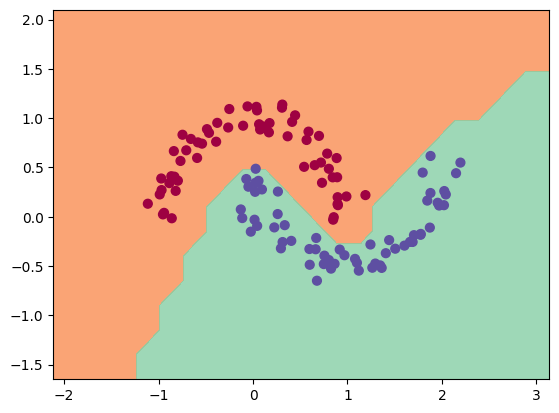

In [42]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

#**PyTorch implementation of MoonDataset**

In [77]:
import torch
from torch.utils.data import Dataset, DataLoader

class MoonDataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

# dataset = MoonDataset(X, y)
# dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# iterate over the dataloader
# for batch_X, batch_y in dataloader:
#   # do something with the batch
#   print(batch_X.shape, batch_y.shape)


In [78]:
X, y = make_moons(n_samples=100, noise=0.1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = MoonDataset(X_train, y_train)
test_dataset = MoonDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False) # No need to shuffle test data

# Now you have separate dataloaders for training and testing


In [21]:
train_dataloader

In [79]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [80]:
batch_size = 64

In [81]:
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 2])
Shape of y: torch.Size([64]) torch.float32


In [82]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [84]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device).long()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [85]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device).long()
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [89]:
epochs = 20000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Streaming output truncated to the last 5000 lines.

Epoch 19168
-------------------------------
loss: 0.016264  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036160 

Epoch 19169
-------------------------------
loss: 0.016771  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036138 

Epoch 19170
-------------------------------
loss: 0.017291  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036111 

Epoch 19171
-------------------------------
loss: 0.016265  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036043 

Epoch 19172
-------------------------------
loss: 0.010956  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036184 

Epoch 19173
-------------------------------
loss: 0.014084  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.036041 

Epoch 19174
-------------------------------
loss: 0.014359  [   64/   80]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.035959 

Epoch 19175
-------------------------------
loss: 0.011645 

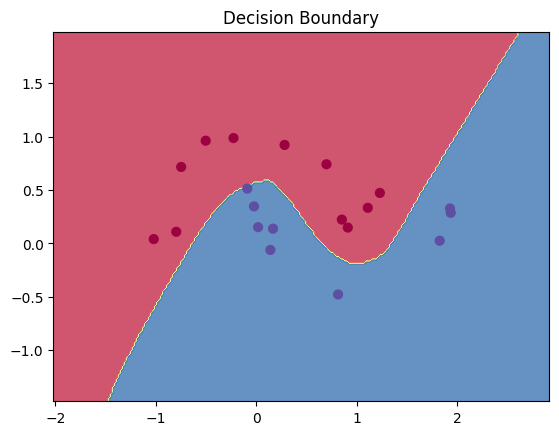

In [90]:

# Assuming X_test is your test data and y_test are the corresponding labels
# Assuming 'model' is your trained PyTorch model

# Set model to evaluation mode
model.eval()

# Create a meshgrid for plotting
h = 0.02  # Step size in the mesh
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Create input tensors from meshgrid
mesh_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(device)

# Get predictions for the meshgrid points
with torch.no_grad():
    Z = model(mesh_tensor)
    Z = torch.argmax(Z, dim=1).cpu().numpy()  # Get predicted class

# Reshape predictions to match meshgrid
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Decision Boundary')
plt.show()
